# Prueba DS

Dado el enunciado a este problema junto con los 2 datasets correspondientes, vamos a comenzar por hacer un análisis exploratorio y descriptivo de dichos datos con la ayuda de varias librerías disponibles en Python y poder llegar así a unas primeras conclusiones. 
Después aplicaremos a estos datos modelos de Machine Learning también con la ayuda de las librerías de Python para poder elaborar así un modelo predictivo entrenado y que en base a dichos datos, sea capaz de predecir el comportamiento de los clientes cuando introduzcamos datos de entrada nuevos.

## Cargar librerías y datos

In [1002]:
%matplotlib inline

import re
import random
from collections import Counter

import pandas as pd
pd.set_option('display.max_colwidth', -1)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy.stats import kstest
sns.set(color_codes=True)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from pandas.plotting import scatter_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import pickle

In [957]:
#Importamos nuestros dos datasets y los guardamos en dos variables distintas
dataset_1 = pd.read_csv('rfqs.csv')
dataset_2 = pd.read_csv('mids.csv')

## Análisis exploratorio y descriptivo de los datos

In [958]:
#El análisis lo vamos a realizar del dataset_1 (peticiones de los clientes) ya que son en base a dicha información las
#predicciones que tendremos que conseguir hacer con nuestro modelo. El dataset_2 (precios en otra plataforma de los bonos) nos
#servirá para poder comparar la efectividad o precisión de dicho modelo con otro modelo entrenado con estos datos de los que 
#podría disponer el banco en caso de demostrarse que son clave para poder hacer mejores predicciones

#Comprobamos las dimensiones de nuestro dataset y nos aseguramos de que no existen registros duplicados, ni valores nulos:
print("Dimensiones:",dataset_1.shape)
print("¿Hay registros duplicados?:",dataset_1.duplicated().any())
print("¿Hay algún valor nulo?:")
print(dataset_1.isnull().any())

dataset_1.head(5)

Dimensiones: (6403, 11)
¿Hay registros duplicados?: False
¿Hay algún valor nulo?:
Unnamed: 0     False
date_time      False
instrument     False
client         False
price          False
mid            False
vol_MM         False
dv01           False
num_dealers    False
side           False
won            False
dtype: bool


,Unnamed: 0,date_time,instrument,client,price,mid,vol_MM,dv01,num_dealers,side,won
0,94075,2019-01-25 15:58:29.0,I,F,112.779,112.7416,2.000,6.0870,5,-1,0
1,94087,2019-01-28 09:28:10.0,B,G,106.065,106.1855,0.500,21.9017,5,1,0
2,94089,2019-01-28 09:40:24.0,F,G,107.607,107.5570,0.975,13.2621,5,-1,0
3,94158,2019-01-29 16:21:06.0,E,F,100.622,100.5820,0.010,4.4853,5,-1,0
4,94194,2019-01-30 16:19:28.0,F,F,107.297,107.2170,0.448,13.2087,5,-1,0


In [959]:
dataset_1.sample(5)

,Unnamed: 0,date_time,instrument,client,price,mid,vol_MM,dv01,num_dealers,side,won
259,168433,2019-09-03 15:11:31.0,D,B,120.439,120.3887,0.053,16.9255,10,-1,0
708,217675,2019-05-20 15:23:06.0,L,G,100.927,100.9559,4.900,5.2080,5,1,0
3845,342413,2019-08-19 13:10:44.0,L,B,102.720,102.7058,20.256,5.0640,4,-1,1
1096,236051,2019-07-08 11:39:21.0,B,A,132.365,132.3204,0.013,28.5886,5,-1,0
5409,377863,2019-03-27 11:07:37.0,B,A,110.978,111.0354,1.500,23.1094,6,1,0


In [960]:
dataset_1.tail(5)

,Unnamed: 0,date_time,instrument,client,price,mid,vol_MM,dv01,num_dealers,side,won
6398,397813,2019-07-31 08:27:39.0,K,B,128.835,128.8701,0.005,7.0343,5,1,0
6399,397824,2019-07-31 15:14:18.0,C,B,111.673,111.6428,0.047,10.2421,5,-1,0
6400,397825,2019-07-31 15:17:39.0,J,B,117.188,117.1953,0.117,11.7868,5,1,0
6401,397848,2019-07-31 07:50:10.0,H,A,113.353,113.3045,2.500,7.2674,5,-1,1
6402,397854,2019-07-31 09:44:24.0,D,A,115.952,115.9248,0.500,16.2913,5,-1,0


In [961]:
#Parece que la primera columna es una especie de ID que nada aporta a nuestro análisis. Comprobamos que el número de valores
#únicos es el mismo que de registros en el dataset (6403)
dataset_1['Unnamed: 0'].nunique()

6403

In [962]:
#Así es por lo que podemos eliminar esa columna, añadiremos otra más con el spread en función de si es compra o venta, 
#renombramos el resto y comprobamos el formato de las variables:
dataset_1=dataset_1.drop(['Unnamed: 0'], axis=1)
array=np.array(dataset_1)
spread=[]
for row in array:
    if row[8]==1:
        spread.append(row[4]-row[3])
    else:
        spread.append(row[3]-row[4])
dataset_1.insert(5,'spread',spread)
dataset_1.columns = [column.lower() for column in dataset_1.columns]
print(dataset_1.shape)
dataset_1.dtypes

(6403, 11)


date_time      object 
instrument     object 
client         object 
price          float64
mid            float64
spread         float64
vol_mm         float64
dv01           float64
num_dealers    int64  
side           int64  
won            int64  
dtype: object

### 1) Análisis de variables numéricas

In [963]:
#Vemos que de las variables en nuestro dataset, hay 3 categóricas (fecha y hora, cliente e instrumento) y el resto son numéricas
#Empezamos realizando un análisis exhaustivo de las variables numéricas sin tener en cuenta las categóricas por ahora.
dataset_1.describe()

,price,mid,spread,vol_mm,dv01,num_dealers,side,won
count,6403.000000,6403.000000,6403.000000,6403.000000,6403.000000,6403.000000,6403.000000,6403.000000
mean,112.694414,112.662200,0.066015,2.636600,11.585256,5.561612,-0.058254,0.112916
std,9.916090,9.906521,0.962069,5.989479,6.910370,2.148954,0.998380,0.316515
min,99.069000,99.082500,-29.757500,0.001000,1.906000,1.000000,-1.000000,0.000000
25%,103.971000,103.911450,0.007900,0.050000,7.120000,5.000000,-1.000000,0.000000
50%,110.751000,110.696200,0.028500,0.650000,9.530200,5.000000,-1.000000,0.000000
75%,117.070500,117.066450,0.053300,3.000000,14.593250,5.000000,1.000000,0.000000
max,147.153000,147.180900,34.866100,131.400000,32.491200,21.000000,1.000000,1.000000


Vemos que hay datos de todas las columnas para todos los registros y podemos sacar unas primeras conclusiones: 

1) Comprobamos que casi el 90% de las peticiones no se cerraron (won=0)

2) Hay más o menos las mismas peticiones de compra que de venta 

3) El número de vendedores a los que los clientes piden precio suele ser 5 

4) La mitad de las cantidades pedidas llegan solo hasta los 650k€ (habiendo cantidades mucho mayores que desplazan la media,  siendo estos quizás otro tipo de clientes)

5) Casi todos los spreads son positivos (lógico pues se puede entender como el beneficio del banco en estas operaciones)

6) Los precios varían poco entre sí, de 99€ a 147€.

Todas estas conclusiones las podremos visualizar mejor con diferentes gráficos:




*Primero vamos a representar la distribución de price, mid, spread y vol_mm con gráficos box and whiskers e histogramas:*
    
#### a) PRICE

PRICE:


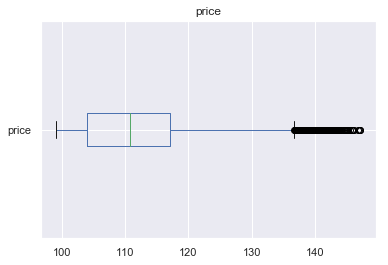

In [964]:
dataset_1['price'].plot(kind='box',title="price",showfliers=True, vert=False)
print("PRICE:")
plt.show()

PRICE:


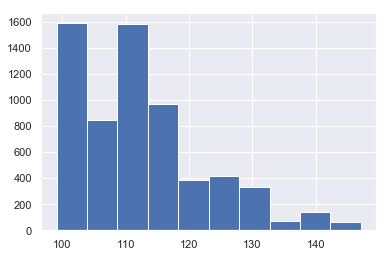

In [965]:
dataset_1['price'].hist()
print("PRICE:")
plt.show()

#### b) MID:

MID:


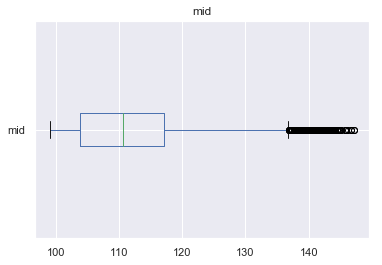

In [966]:
dataset_1['mid'].plot(kind='box',title="mid",showfliers=True, vert=False)
print("MID:")
plt.show()

MID:


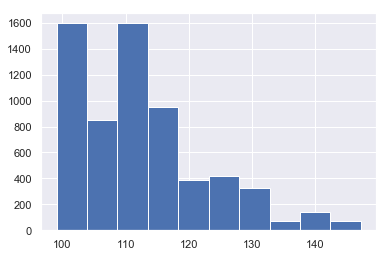

In [967]:
dataset_1['mid'].hist()
print("MID:")
plt.show()

Vemos que, como es lógico, la distribución de los precios dados al cliente y de los alojados en los sistemas del banco es prácticamente idéntica, con unos cuantos outliers que representan precios algo más alejados de la media pero que también son representativos y mantendremos en nuestro dataset

#### c) SPREAD

SPREAD:


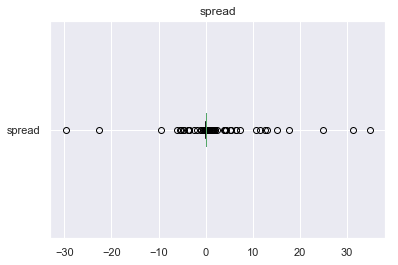

In [968]:
dataset_1['spread'].plot(kind='box',title="spread",showfliers=True, vert=False)
print("SPREAD:")
plt.show()

SPREAD:


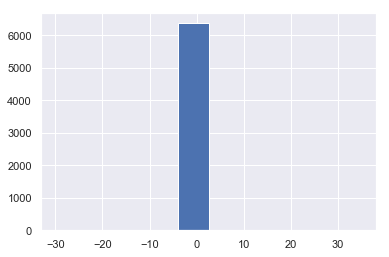

In [969]:
dataset_1['spread'].hist()
print("SPREAD:")
plt.show()

Vemos en el gráfico box and whiskers que hay valores atípicos de spread tan alejados del resto, que nos impiden ver la caja
central. Con el histograma vemos que el número de estos valores atípicos tan alejados es muy pequeño en comparación con todos 
los valores existentes, lo que nos hace pensar que no son valores representativos ya que el spread, entendido como el beneficio
o margen del banco por cada operación que se cierra, deberían ser valores contenidos en un intervalo más definido. Estos datos y sus registros podríamos eliminarlos más tarde a la hora de entrenar a nuestro modelo predictivo. Por ahora los vamos a identificar:

SPREAD:


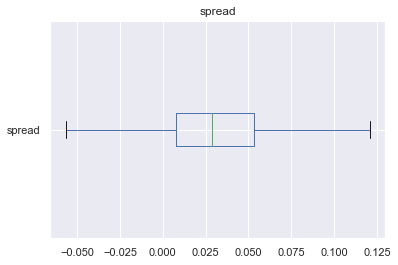

In [970]:
#Creamos una funcion que dado un dataset, la columna correspondiente y los límites del intervalo fuera del que consideraremos 
#los valores atípicos, nos guarde dichos valores en una lista junto con su posición:

def identifyOutliers(dataset, column, downLimit, upperLimit):
    count=0
    outliers=[]
    for i in dataset[column]:
        if (i<downLimit or i>upperLimit):
            outliers.append([count,i])
        count+=1
    return outliers

#Volvemos a pintar el gráfico de caja y bigote sin los valores atípicos que se cogen por defecto para poder visualizar mejor su 
#distribución y elegir un intervalo nosotros mismos:

dataset_1['spread'].plot(kind='box',title="spread",showfliers=False, vert=False)
print("SPREAD:")
plt.show()

In [971]:
#Viendo la distribución elegimos un intervalo algo más grande que la caja central (-0.1 < x < 0.2) para ser conservadores y 
#considerar el menor número de valores atípicos posibles y vemos cuantos registros se saldrían de él:

print(len(identifyOutliers(dataset_1, 'spread', -0.1, 0.2)))


261


Estos valores representan menos de un 4% del total, lo que sugiere que efectivamente tal y como pensábamos son valores atípicos realmente y no representativos, considerando además que el spread es una variable difícil a veces de controlar por parte del banco. Los podríamos eliminar más adelante para evitar confundir a nuestro modelo predictivo pues seguramente serían valores de spread no deseados. 

#### d) VOL_MM

VOL_MM:


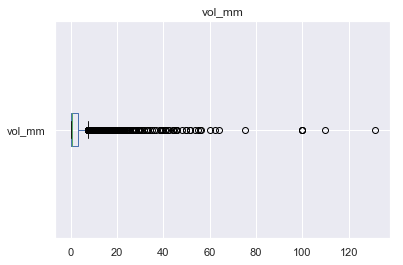

In [972]:
dataset_1['vol_mm'].plot(kind='box',title="vol_mm",showfliers=True, vert=False)
print("VOL_MM:")
plt.show()

VOL_MM:


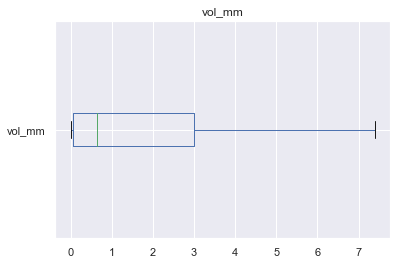

In [973]:
#Vemos que en este caso también hay valores alejados que no nos dejan ver correctamente la caja central. Los ocultamos
#para poder verlos mejor:

dataset_1['vol_mm'].plot(kind='box',title="vol_mm",showfliers=False, vert=False)
print("VOL_MM:")
plt.show()

VOL_MM:


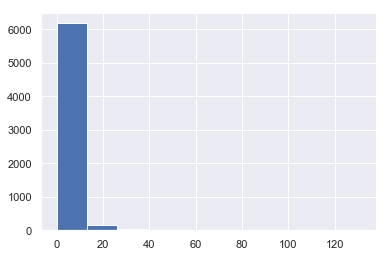

In [974]:
dataset_1['vol_mm'].hist()
print("VOL_MM:")
plt.show()

Esta distribución apoya una de las hipótesis que barajamos antes y es que hubiera clientes que pidieran también cantidades notablemente mayores en sus operaciones debido a que siguen estrategias diferentes al resto, y que quizás convendría separarlos a la hora de crear el modelo predictivo y crear así dos o más modelos distintos (entrenados con datos distintos) que representen lo mejor posible cada una de estas posibles estrategias ya que el comportamiento del cliente esperado debería ser distinto. Abordaremos este estudio en el análisis de las variables categóricas.

#### e) DV01

DV01:


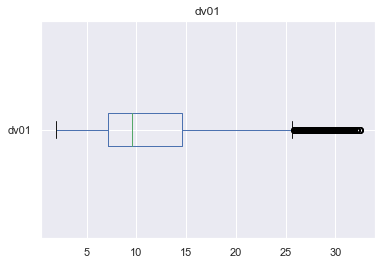

In [975]:
dataset_1['dv01'].plot(kind='box',title="dv01",showfliers=True, vert=False)
print("DV01:")
plt.show()

En este caso el gráfico se ve correctamente aun con los valores atípicos representados. Vemos una distribución que se concentra sobre todo en el intervalo (5,15).
Se podría pensar que debe existir una relación lineal entre dv01, que es la sensibilidad del bono a variaciones en su yield, y el precio de dicho bono. Más adelante vamos a representar la matriz de correlación de todas las variables, buscar dicha relación a ver si efectivamente existe y explicar el por qué hemos supuesto que debía existir. 

#### f) NUM_DEALERS

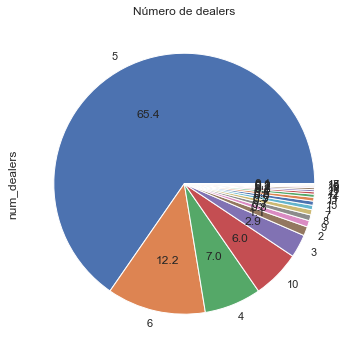

In [976]:
plot = dataset_1['num_dealers'].value_counts().plot(kind='pie', autopct='%.1f', figsize=(6, 6), title='Número de dealers')

Como podemos ver, y al igual que pudimos deducir en nuestras primeras conclusiones, la mayor parte de peticiones se les hace a 5 dealers distintos y entre sólo 4 valores distintos hacen más del 90% de las peticiones. 

#### g) SIDE

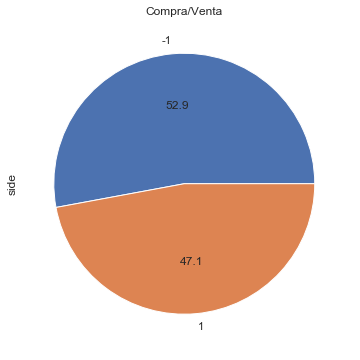

In [977]:
plot = dataset_1['side'].value_counts().plot(kind='pie', autopct='%.1f', figsize=(6, 6), title='Compra/Venta')

Al igual que vimos rápidamente al principio, está bastante equilibrado el número de peticiones de venta con peticiones de compra

#### h) WON

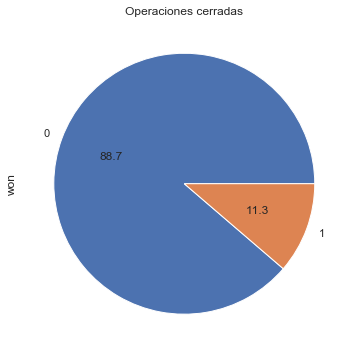

In [978]:
plot = dataset_1['won'].value_counts().plot(kind='pie', autopct='%.1f', figsize=(6, 6), title='Operaciones cerradas')

Vemos al igual que al principio que casi el 90% de las peticiones no se cerraron. Debido a que es una proporción algo desigualada, deberemos prestar especial atención a que, a la hora de configurar nuestro modelo predictivo, el dataset de entrenamiento contenga los suficientes registros de operaciones cerradas para que así el modelo pueda detectar aquellas caracteríticas que llevan a que dicha operación se cierre.

#### i) MATRIZ DE CORRELACIÓN

Por último, para hallar posibles relaciones lineales entre estas variables numéricas recurrimos a la matriz de correlación que nos mide el coeficiente de Pearson entre cada pareja de nuestras variables numéricas. Este coeficiente va de -1 a +1, pudiendo pasar por todos los valores intermedios y significando -1 una relación lineal negativa, 0 ninguna relación lineal y +1 una relación lineal positiva.

In [979]:
#Para buscar relaciones entre las variables numéricas creamos la matriz de correlación
dataset_1.corr()

,price,mid,spread,vol_mm,dv01,num_dealers,side,won
price,1.000000,0.995272,0.045396,-0.131289,0.626716,-0.017484,0.032727,-0.018153
mid,0.995272,1.000000,0.023750,-0.134843,0.629666,-0.015411,0.039245,-0.017192
spread,0.045396,0.023750,1.000000,0.011265,0.021742,-0.005404,-0.029539,-0.019489
vol_mm,-0.131289,-0.134843,0.011265,1.000000,-0.104036,-0.217100,0.046580,0.094793
dv01,0.626716,0.629666,0.021742,-0.104036,1.000000,-0.101229,0.004767,-0.016957
num_dealers,-0.017484,-0.015411,-0.005404,-0.217100,-0.101229,1.000000,-0.039207,-0.110242
side,0.032727,0.039245,-0.029539,0.046580,0.004767,-0.039207,1.000000,0.033177
won,-0.018153,-0.017192,-0.019489,0.094793,-0.016957,-0.110242,0.033177,1.000000


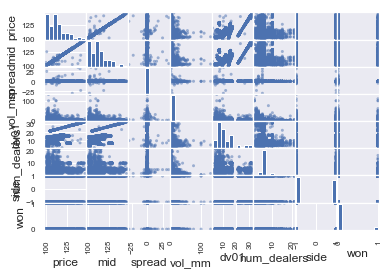

In [980]:
#Gráficamente esto se podría ver con scatter_matrix:
scatter_matrix(dataset_1)
plt.show()

Podemos obervar: 
- Hay una relación lineal positiva casi perfecta entre precio y mid. Esto es lógico como ya dedujimos en apartados anteriores pues price y mid son dos valores casi idénticos en cada una de las peticiones, siendo su diferencia el spread que como también hemos visto toma valores muy pequeños y que varían por lo general en un intervalo también muy peuqeño.
- Como predijimos cuando analizamos la distribución de dv01, efectivamente vemos que hay una relación lineal positiva moderada entre el precio del bono y dv01, que como dijimos es sensibilidad del bono ante variaciones en su yield o rentabilidad. Esto es lógico pues los bonos con mayor precio suelen ser aquellos de los que se espera obtener mayor beneficio, su precio viene justificado por su rentabilidad. Si la rentabilidad de estos bonos con elevado precio cambiase, esto afectaría notablemente en su precio inmediatamente y es así como se define la sensibilidad. Por ello a mayor precio, mayor rentabilidad y mayor sensibilidad.
- El resto de variables muestran una correlación entre sí de prácticamente 0, por lo que no hay ninguna relación lineal entre ellas.

### 2) Análisis de variables catégoricas

#### a) CLIENTES

In [981]:
#Comprobamos la distribución de los clientes

print(dataset_1.groupby('client')['won'].count())

client
A    3146
B    1834
C    394 
D    391 
F    302 
G    336 
Name: won, dtype: int64


Vemos que tenemos 6 clientes distintos(dos de ellos, A y B, representan casi el 80% de las peticiones) pero como dijimos antes, el análisis de los clientes que nos parece más interesante es el que tiene que ver con las cantidades de las operaciones y las posiblemente diferentes estrategias que sigan unos y otros en función de dichas cantidades

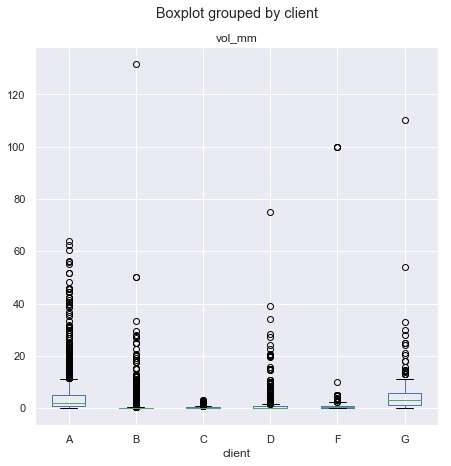

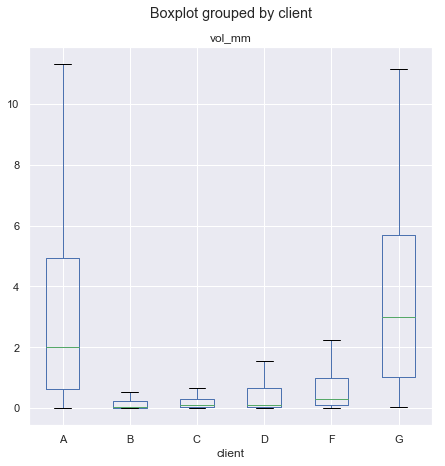

In [982]:
#Creamos un gráfico box and whiskers de la cantidad pedida pero individuales para cada cliente y vemos así la distribución de 
#cada uno. Vemos primero representados los valores atípicos y luego sin ellos:

dataset_1.boxplot('vol_mm','client',grid=True, figsize=(7,7), showfliers=True)
dataset_1.boxplot('vol_mm','client',grid=True, figsize=(7,7), showfliers=False)
plt.show()

Vemos que aunque hay valores atípicos para todos los clientes y que distan mucho entre sí y de la caja central en algunos casos, claramente se pueden identificar dos tendencias diferentes. Una en la que la mayor parte de las operaciones no llegan a 1M€ de cantidad y que correspondería con los clientes B, C, D y F, y otra tendencia en la que las operaciones son en la mayor parte de los casos de cantidades entre 2M€ y 5M€ y que corresponde con los clientes A y G. 
Por esta distinta tendencia o estrategia a la hora de operar, podría considerarse la opción de realizar dos modelos por separado que intenten predecir estos comportamientos distintos. Uno de ellos aplicándolo únicamente a los clientes A y G, y el otro al resto de clientes.

#### b) INSTRUMENTOS

In [983]:
#Comprobamos la distribución de los instrumentos

print(dataset_1.groupby('instrument')['won'].count())

instrument
A    644
B    837
C    718
D    657
E    516
F    545
G    428
H    432
I    442
J    449
K    351
L    384
Name: won, dtype: int64


Vemos que tenemos 12 instrumentos diferentes y que se reparten a lo largo de las peticiones de manera más o menos equilibrada. Una relación interesante que podríamos sacar es la de cantidad-instrumento al igual que hicimos anteriormente y para ver cuáles sería los instrumentos que absorben las peticiones que representan mayor cantidad de dinero. Si hubiera una relación clara sería algo lógico y comprensible pues se entiende que ciertos instrumentos, debido a sus características, podrían ser objeto de operaciones que involucran grandes cantidades.

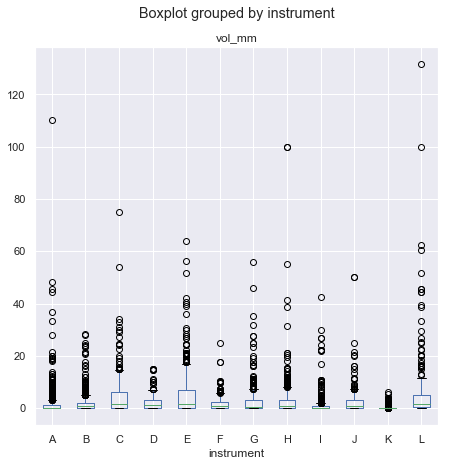

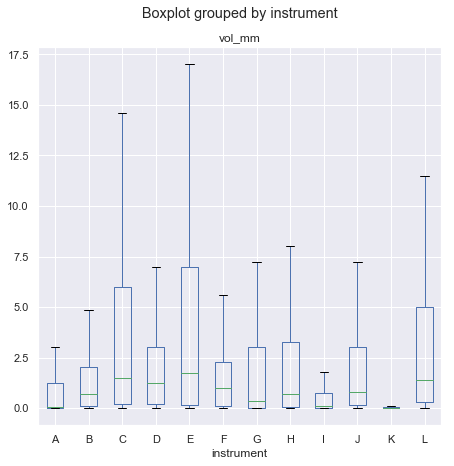

In [984]:
#Creamos un gráfico box and whiskers de la cantidad pedida pero individuales para cada instrumento como hicimos antes y vemos 
#así la distribución de cada uno. Vemos primero representados los valores atípicos y luego sin ellos:

dataset_1.boxplot('vol_mm','instrument',grid=True, figsize=(7,7), showfliers=True)
dataset_1.boxplot('vol_mm','instrument',grid=True, figsize=(7,7), showfliers=False)
plt.show()

No parece que haya una relación clara ya que las medianas para todos los instrumentos están por debajo de los 2M€. Sí puede apreciarse sin embargo que los instrumentos C, E y L parecen ser más propensos a recibir peticiones de mayor cantidad, debido quizás a sus características como hemos dicho.

No vamos a analizar la variable de fecha y hora. Es una variable cuyo estudio nada aporta a nuestro análisis y tampoco se usará para el modelo predictivo por lo que la desecharemos a la hora de entrenarlo. 
Si servirá para poder relacionar el dataset_1 con el dataset_2

## Modelo Predictivo

Después de haber realizado un análisis exploratorio de los datos de nuestro dataset_1 y haber visto que no hay ninguna relación lineal global entre las variables numéricas, haber considerado también las relaciones que hemos encontrado respecto a las variables categóricas y que nos encontramos ante un problema de clasificación (operación cerrada sí o no) concluimos que el mejor modelo a implantar para este caso es Random Forest. Antes de aplicar o probar nuestro modelo, tenemos que acondicionar los datos.

### Modelo, parámetros y  métricas:

Vamos a definir nuestro modelo, hallar los parámetros óptimos y sus métricas correspondientes. Vamos por partes:

In [985]:
#Lo primero que tenemos que hacer es transformar las variables categóricas en numéricas para poder introducirlas en el modelo:
dataset_1_model=dataset_1.copy()
dataset_1_model["client"]= dataset_1_model["client"].replace("A", 1)
dataset_1_model["client"]= dataset_1_model["client"].replace("B", 2)
dataset_1_model["client"]= dataset_1_model["client"].replace("C", 3)
dataset_1_model["client"]= dataset_1_model["client"].replace("D", 4)
dataset_1_model["client"]= dataset_1_model["client"].replace("F", 5)
dataset_1_model["client"]= dataset_1_model["client"].replace("G", 6)
dataset_1_model["instrument"]= dataset_1_model["instrument"].replace("A", 1)
dataset_1_model["instrument"]= dataset_1_model["instrument"].replace("B", 2)
dataset_1_model["instrument"]= dataset_1_model["instrument"].replace("C", 3)
dataset_1_model["instrument"]= dataset_1_model["instrument"].replace("D", 4)
dataset_1_model["instrument"]= dataset_1_model["instrument"].replace("E", 5)
dataset_1_model["instrument"]= dataset_1_model["instrument"].replace("F", 6)
dataset_1_model["instrument"]= dataset_1_model["instrument"].replace("G", 7)
dataset_1_model["instrument"]= dataset_1_model["instrument"].replace("H", 8)
dataset_1_model["instrument"]= dataset_1_model["instrument"].replace("I", 9)
dataset_1_model["instrument"]= dataset_1_model["instrument"].replace("J", 10)
dataset_1_model["instrument"]= dataset_1_model["instrument"].replace("K", 11)
dataset_1_model["instrument"]= dataset_1_model["instrument"].replace("L", 12)

In [986]:
dataset_1_model.head(5)

,date_time,instrument,client,price,mid,spread,vol_mm,dv01,num_dealers,side,won
0,2019-01-25 15:58:29.0,9,5,112.779,112.7416,0.0374,2.000,6.0870,5,-1,0
1,2019-01-28 09:28:10.0,2,6,106.065,106.1855,0.1205,0.500,21.9017,5,1,0
2,2019-01-28 09:40:24.0,6,6,107.607,107.5570,0.0500,0.975,13.2621,5,-1,0
3,2019-01-29 16:21:06.0,5,5,100.622,100.5820,0.0400,0.010,4.4853,5,-1,0
4,2019-01-30 16:19:28.0,6,5,107.297,107.2170,0.0800,0.448,13.2087,5,-1,0


In [987]:
#Luego vamos a eliminar la columna de fecha y hora de nuestro dataset_1_model que como dijimos no aporta nada en el modelo:

dataset_1_model=dataset_1_model.drop('date_time', axis=1)

#Consideramos que teniendo el valor del spread en nuestro dataset, no tiene sentido tener price y mid, ya que es redudante. De
#hecho, tener más datos y columans y además tan parecidas entre sí podría confundir al modelo:

dataset_1_model=dataset_1_model.drop(['price', 'mid'], axis=1)
dataset_1_model.head(1)

,instrument,client,spread,vol_mm,dv01,num_dealers,side,won
0,9,5,0.0374,2.0,6.087,5,-1,0


In [988]:
#Ahora tenemos que dividir nuestro dataset en dos partes, las variables independientes X que corresponden con todas las columnas
#menos a la última 'won' y la variable dependiente Y que es la última columna 'won' ya que es el output que pretendemos obtener
#de nuestro modelo, saber si la operación se cerrará o no

array = dataset_1_model.values
X = array[:,0:7]
Y = array[:,7]

In [994]:
#Utilizamos el método GridSearchCV para encontrar los parámetros de nuestro modelo Random Forest que hacen que éste sea óptimo y
#tenga la mayor precisión alcanzable. Este cálculo llevará un tiempo:

param_grid = {'n_estimators':np.array([100,250,500,750]),'max_features':np.array([2,3,4,5])}
model = RandomForestClassifier()
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid.fit(X, Y)
print(grid.best_score_)
print(grid.best_estimator_.n_estimators)
print(grid.best_estimator_.max_features)

0.8833359362798688
500
4


In [995]:
#Ahora aplicamos estos parámetros n_estimators=500 y max_features=4 a nuesto modelo y le aplicamos una validación conocida como 
#K-Fold Cross Validation que divide nuestro set de datos X e Y en k=10 partes y empieza a hacer train con 9 de ellas y test con
#la restante. Esta parte test va cambiando a lo largo de las 10 partes y se va guardando una medición de la precisión del modelo
#en cada una de estas iteraciones, obteniendo al final una media de todas ellas que representa la precisión estimada del modelo 
#con ese dataset

kfold = KFold(n_splits=10, random_state=10)
model = RandomForestClassifier(n_estimators=500, max_features=4)
results = cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

0.88474380850234


Obtenemos finalmente una precisión o accuracy estimada para este modelo de casi el 88.5% lo que indica que es un modelo muy sólido y apto para nuestro problema. Por tanto establecemos definitivamente este modelo como el que utilizaremos, un Random Forest Classifier con parámetros n_estimators=500 y max_features=4

### 1er Modelo:

Primero crearemos un modelo entrenado con los datos del dataset_1. Aunque ya hemos hecho estimaciones de la precisión que tendrá este modelo con los parámetros establecidos y entrenado con estos datos (88,5%), vamos a comprobar por nosotros mismos esta vez cómo entrenando al modelo con una parte de dichos datos y validando con la parte restante las predicciones que obtengamos con el mismo, obtendremos una precisión muy parecida a la estimada, pero en este caso es ya calculada de forma real. 

In [996]:
#Ahora dividimos nuestra X e Y en dos partes, una de entrenamiento y otra de validación, para comprobar así de forma real y "con
#nuestras manos" la efectividad o precisión de nuestro modelo. Un 85% del dataset será entrenamiento y un 15% validación.

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.15, random_state=10)

In [997]:
#Entrenamos a nuestro modelo con X_train e Y_train
model = RandomForestClassifier(n_estimators=500, max_features=4)
model.fit(X_train, Y_train)

#Y hacemos predicciones en base a X_validation
predictions = model.predict(X_validation)

In [998]:
#Comparamos nuestras predicciones con Y_validation y sacamos parámetros como la precisión, matriz de confusión y el 
#classification report

print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.8928199791883454
[[830  21]
 [ 82  28]]
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94       851
         1.0       0.57      0.25      0.35       110

   micro avg       0.89      0.89      0.89       961
   macro avg       0.74      0.61      0.65       961
weighted avg       0.87      0.89      0.87       961



Vemos que obtenemos una precisión de prácticamente el 90% pero si miramos en detalle el classification report, vemos que en las predicciones sobre operaciones que sí se cierran sólo se obtiene una precisión del 57%. El siguiente paso será ver si cuando utilicemos como datos de entrenamiento los del dataset_2, obtendremos un modelo más fiable o no. Si es así, este segundo modelo será el que usaremos para hacer nuestras predicciones.
Por ahora, vamos a entrenar este modelo con el dataset_1 completo y a guardarlo:

In [999]:
#Lo entrenamos con todo el dataset_1 para dejarlo listo para poder hacer predicciones en base a datos nuevos
model = RandomForestClassifier(n_estimators=500, max_features=4)
model.fit(X, Y)
print("Entrenamiento completado")

Entrenamiento completado


In [1000]:
#Y ahora lo guardamos
filename = 'model1.sav'
pickle.dump(model, open(filename, 'wb'))

### 2º Modelo:

Ahora tenemos que crear un modelo entrenado con los datos del dataset_2 para compararlo con el anterior. Para ello utilizaremos la misma estructura que el dataset_1 pero introduciéndole los datos de 'mid' correspondientes al dataset_2. Viendo las columnas que existen en el dataset_2 y que son 'date_time', 'mid' y 'instrument', esto lo conseguiremos mapeando por instrumento y por la fecha anterior más cercana a la de la petición del cliente.

He explorado varias formas de intentar llevar a cabo este 'mapeo' en python, sin embargo no he sido capaz por lo que a partir de aquí continúo redactando los pasos que habría que seguir en caso de haber podido hacerlo.

Una vez hubiéramos conseguido sustituir los datos de 'mid' del dataset_1 por los del dataset_2 en base al instrumento y la fecha, tendríamos listo nuestro nuevo dataset_3 con el que entrenar nuestro modelo. Al haber un nuevo 'mid' los valores de 'spread' también cambiarían.
Ya teniendo listo el dataset_3 llevaríamos a cabo las mismas transformaciones que hicimos con el dataset_1 (eliminar columna de fecha que ya sirvió para el mapeo, eliminar columna de 'price' y 'mid' que ya sirvieron para recalcular el spread, transformar los intrumentos y clientes en números, dividir en variables independientes X y dependientes Y, dividir de nuevo en set de entrenamiento y set de validación)
Una vez hechas estas transformaciones, utilizaríamos este dataset_3 para entrenar el modelo de Random Forest customizado con los parámetros que calculamos como óptimos. Llevaríamos a cabo predicciones con este modelo entrenado y las compararíamos como ya hicimos en el caso anterior con el set de validación y calcularíamos la precisión y el classification report. Mis suposiciones me llevan a pensar que este modelo arrojará una precisión mayor que la del anterior, especialmente en los casos en que la operación se cierra donde el incremento de precisión será mucho más notable.
Una vez comprobado esto, se podrían sacar las conclusiones y responder a las cuestiones que plantea el enunciado.

## Conclusiones:

- Hemos realizado un análisis exploratorio y descriptivo de los datos del dataset_1:

    a) Hemos observado la distribución de las variables tanto numéricas como categóricas. De aquí hemos sacado varias   conclusiones acerca de la relación que tienen entre sí las varibles, como los clientes y la cantidad de dinero de las operaciones que demandan (pudiendo como dijimos considerar de esta manera dos modelos distintos que representen dos estrategias distintas, aunque no hemos optado por ello en este caso), algunos valores atípicos no representativos de spread (que se podrían eliminar también aunque son muy pocos en comparación con el total) o la relación entre la sensibilidad y el precio.
    
    b) Hemos calculado la matriz de correlación de las variables numéricas, viendo que no existe ninguna relación lineal global ni nada que se le parezca, lo que nos ayudó a decidir implementar un modelo de Random Forest Classifier
    
    
- Hemos preprocesado los datos del dataset_1 para poder usarlos en el modelo Random Forest, el cual hemos previamente buscado sus parámetros óptimos mediante GridSearchCV además de hacer una estimación de su performance y precisión mediante KFoldCrossValidation. Una vez entrenado este modelo con el dataset_1 hemos obtenido varias métricas


- Creamos el dataset_3 en base a los dos primeros y lo usamos para entrenar y medir la performance del mismo modelo, obteniendo mejores resultados de precisión


- De esto último se deduce que, al contar con datos de precios más fiables, es más fácil predecir si el cliente cerrará la operación o no


- Contestando a la pregunta del enunciado acerca del impacto por no contar con datos de alta frecuencia, habría que cuantificar la diferencia de precisión o performance del modelo en función de ser entrenado con unos u otros datos pero la conclusión es que sí tiene impacto el no poder contar con datos de alta frecuencia ya que vemos que con unos datos u otros el modelo predice mejor o peor, con el enorme impacto que esto tiene en el banco y en el negocio.